# Fit MRP parameters to a suite of simulation data simultaneously

In this example, we grab haloes from the publicly available $\nu^2$GC simulation suite and show how MRP can be fit to the haloes of 4 simulations simultaneously. In this case, the 4 simulations have different box sizes, so they probe different parts of the mass function more or less effectively. By combining them, we can get a good handle on a wide range of the mass function.

Do note that this example is not quick. It takes a while to *get* the data, let alone run the MCMC on it. You may want to generate some smaller fake datasets to have a play.

**The plots from this example are used in MRP as Figures 3 and 4.**

In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from os.path import join, splitext, exists, expanduser

# Mrpy imports
from mrpy.fitting.fit_sample import SimFit
from mrpy import MRP

from chainconsumer import ChainConsumer

In [2]:
fig_folder = expanduser("~")
data_folder = expanduser("~")

## Preparing the data

First you'll need to get the data. These are the files you'll need to download (beware, at least one of them is 12Gb alone):

http://www2.ccs.tsukuba.ac.jp/Astro/Members/ishiyama/nngc/Data/n2gc-m_z0.fof.bz2

http://www2.ccs.tsukuba.ac.jp/Astro/Members/ishiyama/nngc/Data/n2gc-h1_z0.fof.bz2

http://www2.ccs.tsukuba.ac.jp/Astro/Members/ishiyama/nngc/Data/n2gc-m_z0.rockstar.bz2


Then unzip them. **NOTE: you don't need to run this section if you've already got the data and compactified it**

First of all, we need to pare down the huge files. We can do this in a few ways:

   * We only care about the Mass column, so we can delete everything else
   * We only care about unique halo masses (and the quantity of each), so we can "tabulate" the data
   * We keep only haloes with 40 or more particles (this limit is taken from the paper accompanying the catalogue)
   
These operations reduce the file size by about a factor of 100-1000, and make the subsequent MCMC runs much faster.

Something else to consider is that the fastest way to read in the data files and reduce them is to do it in one big chunk with numpy. However, this takes a lot of memory. So instead we read them line by line.

With these considerations, we implement the following functions.

### Compress Data

In [3]:
def strip_and_compress(fname,fout,mpart=None,Nmin=0,Nmax=np.inf, force=False):
    unique_masses = {}
    ftype = splitext(fname)[1][1:]

    if not force and exists(fout):
        return 
    
    with open(fname) as fin:
        for line in fin:
            l = line.strip()
            
            # Skip comments
            if l.startswith("#"):
                continue
            
            else:
                if ftype=="fof":
                    npart = int(l.split()[-1])
                elif ftype=="rockstar":
                    npart = int(l.split()[7])
                    
                # Reject the entry if it is less than Nmin
                if npart < Nmin:
                    continue
                elif npart > Nmax:
                    continue
                    
                # Calculate the mass of the halo
                if ftype=="fof":
                    mvir = mpart * npart
                elif ftype=="rockstar":
                    mvir = float(l.split()[21]) # Corresponds to M200b
                    
                # Add it to the final unique mass dict
                if mvir in unique_masses:
                    unique_masses[mvir] += 1
                else:
                    unique_masses[mvir] = 1

    # Convert the dict of values into a 2D array of masses and number of occurrences
    out = np.array([[k,v] for k,v in unique_masses.iteritems()])
    
    print "Compressed {} to {} percent".format(fname,100*len(out[:,1])/sum(out[:,1]))
    
    # Save the data to a table file
    np.savetxt(fout,out)

Now actually do the stripping and compressing of the files. We save the data in new files with an appended ".compact". Note also we limit the size of the halos, to be in line with the quoted values from the I15 paper. There is in fact at least 1 outlier beyond these limits.

In [76]:
FORCE = False

strip_and_compress(join(data_folder,"n2gc-h1_z0.fof"),
                   join(data_folder, "n2gc-h1_z0.fof.compact"),2.75e7,100,17476256)
strip_and_compress(join(data_folder,"n2gc-m_z0.fof"), 
                   join(data_folder, "n2gc-m_z0.fof.compact"),2.2e8,100,12120576)

strip_and_compress(join(data_folder,"n2gc-m_z0.rockstar"), 
                   join(data_folder, "n2gc-m_z0.rockstar.compact"),force=FORCE,
                   Nmin=100)

strip_and_compress(join(data_folder,"n2gc-h1_z0.rockstar"), 
                   join(data_folder, "n2gc-h1_z0.rockstar.compact"), force=FORCE,
                   Nmin=100)


Compressed /home/steven/Documents/DataSets/n2gc/n2gc-m_z0.rockstar to 0.219503952011 percent
Compressed /home/steven/Documents/DataSets/n2gc/n2gc-h1_z0.rockstar to 0.949670196418 percent


### Read in Tabulated Data

First up, read in the compact data we just created.

In [4]:
# Read in the data from file
def get_raw_data(folder, sims=['h1','m'],ftype="fof",mmin=None,mmax=None):
    m = []
    nm = []
    for sim in sims:
        data = np.genfromtxt(join(folder,"n2gc-{}_z0.{}.compact".format(sim,ftype)))
        m.append(data[:,0])
        nm.append(data[:,1])
        
    if mmin is not None:
        for i,mm in enumerate(mmin):
            nm[i] = nm[i][m[i]>mm]
            m[i] = m[i][m[i]>mm]
    if mmax is not None:
        for i,mm in enumerate(mmax):
            nm[i] = nm[i][m[i]<mm]
            m[i] = m[i][m[i]<mm]
            
    return m,nm

We read in both FOF and SO halos with similar parameters, and store everything in the ``data`` dictionary.

In [77]:
data = {'fof':{}, "so":{}}

# FOF halos
data['fof']['m'], data['fof']['nm'] = get_raw_data(data_folder, ['h1','m'], 
                                                   mmin=[2.75e9,2.2e10],mmax=[2e13,7e14])
data['fof']['weights'] = [data['fof']['nm'][0]/140.0**3, data['fof']['nm'][1]/560.0**3]
print "Total number of FOF haloes: ", np.sum([np.sum(x) for x in data['fof']['nm']])
print "Total number of *unique* FOF haloes: ", np.sum([len(x) for x in data['fof']['m']])
print "-"*40
# SO halos
data['so']['m'], data['so']['nm'] = get_raw_data(data_folder, ['h1','m'], ftype='rockstar', 
                                                 mmin=[2.75e9,2.2e10],mmax=[2e13,7e14])
data['so']['weights'] = [data['so']['nm'][0]/140.0**3, data['so']['nm'][1]/560.0**3]
print "Total number of SO haloes: ", np.sum([np.sum(x) for x in data['so']['nm']])
print "Total number of *unique* SO haloes: ", np.sum([len(x) for x in data['so']['m']])

Total number of FOF haloes:  24640920.0
Total number of *unique* FOF haloes:  141278
----------------------------------------
Total number of SO haloes:  24245670.0
Total number of *unique* SO haloes:  109419


## Running the fits

We'll run the fits with the ``emcee`` package (via a routine built in to ``mrpy``), but also with an optimization solver. The in-built function is able to utilise the tabulation of data we have performed already, and can do the suites simultaneously.

### Fitting with MCMC

In [78]:
# Create the fitting class instance. This will have uniform priors.
fitobj_fof = SimFit(data['fof']['m'],data['fof']['nm'],
                V=[140.0**3,560.0**3],
                alpha_bounds = (-1.99,-1.5), hs_bounds=(12,16),
                beta_bounds=(0.2,1.5),lnA_bounds=(-50,-10))

fitobj_so  = SimFit(data['so']['m'],data['so']['nm'],
                   V=[140.0**3,560.0**3],
                   alpha_bounds = (-1.99,-1.5), hs_bounds=(12,16),
                   beta_bounds=(0.2,1.5),lnA_bounds=(-50,-10))

In [79]:
# We don't use these, but they can be useful if something goes wrong.
downhill_res_fof = fitobj_fof.run_downhill(lnA0=-40.0)
downhill_res_so =  fitobj_so.run_downhill(lnA0=-40.0)

In [80]:
# Run the mcmc. 
# We set 300 chains to warmup, but we can extend this later if we need to manually.
# Also, we start the chains in a small ball around the best (downhill) optimization solution using opt_init=True.
#fitobj_fof.run_mcmc(nchains=50,warmup=200,iterations=500,opt_init=True,threads=8)
fitobj_so.run_mcmc(nchains=50,warmup=200,iterations=500,opt_init=True,threads=8)

First off we want to look at a few key diagnostics of the chains to check whether everything's okay.

In [81]:
print "Acceptance fraction for FOF (min, max, mean): ", fitobj_fof.mcmc_res.acceptance_fraction.min(), fitobj_fof.mcmc_res.acceptance_fraction.max(), fitobj_fof.mcmc_res.acceptance_fraction.mean()
print "Acceptance fraction for SO (min, max, mean): ", fitobj_so.mcmc_res.acceptance_fraction.min(), fitobj_so.mcmc_res.acceptance_fraction.max(), fitobj_so.mcmc_res.acceptance_fraction.mean()

Acceptance fraction for FOF (min, max, mean):  0.518 0.622 0.57288
Acceptance fraction for SO (min, max, mean):  0.542 0.648 0.58912


These acceptance fractions are somewhat high, but probably okay. We'll check burnin as well soon.

In [5]:
def gelman_rubin(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    thb = np.mean(chain, axis=1)
    thbb = np.mean(thb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1) * np.sum((thbb - thb)**2, axis=0)
    var_th = (n - 1.) / n * W + 1. / n * B
    R = np.sqrt(var_th / W)
    return R

In [82]:
ChainConsumer().add_chain(fitobj_fof.mcmc_res.chain.reshape((-1,4)), walkers = 50).diagnostic.gelman_rubin(threshold=0.1)
ChainConsumer().add_chain(fitobj_so.mcmc_res.chain.reshape((-1,4)), walkers = 50).diagnostic.gelman_rubin(threshold=0.1)

Gelman-Rubin Statistic values for chain 0
Param 0: 1.04796 (Passed)
Param 1: 1.04777 (Passed)
Param 2: 1.09876 (Passed)
Param 3: 1.05742 (Passed)
Gelman-Rubin Statistic values for chain 0
Param 0: 1.06547 (Passed)
Param 1: 1.06030 (Passed)
Param 2: 1.06584 (Passed)
Param 3: 1.06507 (Passed)


True

We see that the chains have converged (R < 1.1).

Since the fitting takes some time, we save the main results, i.e. the chain, to file here so that we can begin again at any time without running the MCMC. Thus the following analysis only uses the chains as written to file, rather than the full fit objects just created.

In [83]:
np.savez("n2gc_analysis/n2gc_mcmc_chain_fof",chain=fitobj_fof.mcmc_res.chain)
np.savez("n2gc_analysis/n2gc_mcmc_chain_so",chain=fitobj_so.mcmc_res.chain)

In [6]:
chain_so = np.load("n2gc_analysis/n2gc_mcmc_chain_so.npz")['chain']
chain_fof = np.load("n2gc_analysis/n2gc_mcmc_chain_fof.npz")['chain']

## Analysis

### Traceplot
The first thing we might want to do with each fit is to check its traceplot, and determine if the burnin was sufficient. 

In [7]:
def traceplot(keys,chains):
    f, ax = plt.subplots(len(keys), 1, sharex=True, figsize=(8, 2.5 * len(keys)))
    for i, (key, chain) in enumerate(zip(keys,chains.T)):
        ax[i].plot(chain, color="black", alpha=0.2)
        ax[i].set_ylabel(key,fontsize=16)
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    return f

Plot both cases:

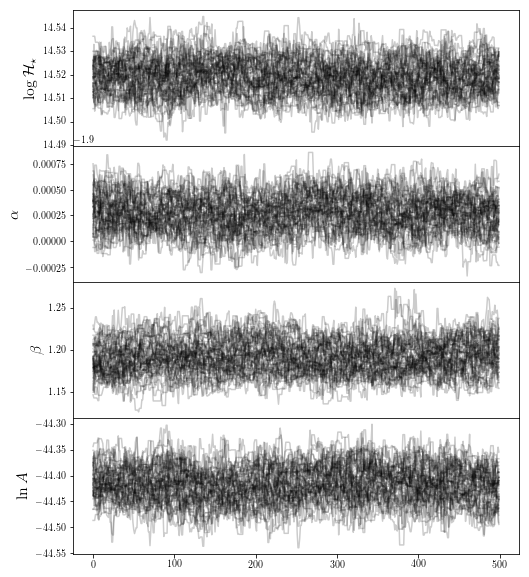

In [44]:
fig0 = traceplot([r"$ \log \mathcal{H}_\star$",r"$\alpha$",r'$\beta$',r"$\ln A$"],chain_fof)
plt.show()

It seems like a reasonable burn-in time has been met for the FOF halos, so we're happy we trust our sample.

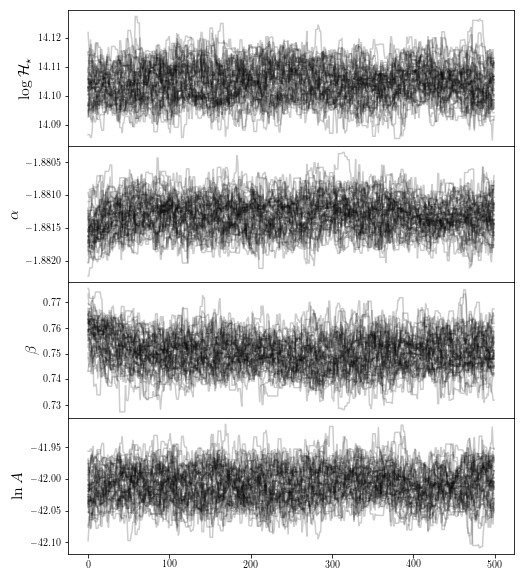

In [86]:
fig0 = traceplot([r"$ \log \mathcal{H}_\star$",r"$\alpha$",r'$\beta$',r"$\ln A$"],chain_so)
plt.show()

The SO halos however have moved significantly, possible due to a poor downhill-gradient optimization. We remove the firs parts of the chain:

In [87]:
chain_so = chain_so[:,100:,:]

### Basic Results

We'd like to know the pure basic results: mean, median, mode, standard deviation etc.

In [51]:
print "Mean: ", np.mean(chain_fof,axis=(0,1))
print "Median: ", np.median(chain_fof,axis=(0,1))
print "Mode: ", fitobj_fof.mcmc_res.flatchain[np.argmax(fitobj_fof.mcmc_res.flatlnprobability),:]
print "Std Dev.: ", np.std(chain_fof,axis=(0,1))
print "Covariance: ", np.cov(chain_fof.reshape((-1,4)).T)
print "Relative Uncertainty: ", np.std(chain_fof,axis=(0,1))*100/np.mean(chain_fof,axis=(0,1))
from mrpy.base.core import log_mass_mode
print "Log Mass Mode: ", np.log10(log_mass_mode(*np.mean(chain_fof[:,:,:3],axis=(0,1))))

Mean:  [ 14.51918594  -1.89972215   1.19198794 -44.41676165]
Median:  [ 14.51921005  -1.89971928   1.19135641 -44.41679216]
Mode:  [ 14.51964269  -1.89972233   1.19189829 -44.41885557]
Std Dev.:  [ 0.00715219  0.00016809  0.0194396   0.03367548]
Covariance:  [[  5.11558477e-05  -1.68702393e-07  -1.92940482e-05  -2.09231989e-04]
 [ -1.68702393e-07   2.82549206e-08  -1.01344465e-06   1.83532519e-06]
 [ -1.92940482e-05  -1.01344465e-06   3.77913140e-04  -2.41123515e-04]
 [ -2.09231989e-04   1.83532519e-06  -2.41123515e-04   1.13408347e-03]]
Relative Uncertainty:  [ 0.04926026 -0.00884806  1.63085537 -0.07581706]
Log Mass Mode:  13.617275083


In [88]:
print "Mean: ", np.mean(chain_so,axis=(0,1))
print "Median: ", np.median(chain_so,axis=(0,1))
print "Mode: ", fitobj_so.mcmc_res.flatchain[np.argmax(fitobj_so.mcmc_res.flatlnprobability),:]
print "Std Dev.: ", np.std(chain_so,axis=(0,1))
print "Covariance: ", np.cov(chain_so.reshape((-1,4)).T)
print "Relative Uncertainty: ", np.std(chain_so,axis=(0,1))*100/np.mean(chain_so,axis=(0,1))
from mrpy.base.core import log_mass_mode
print "Log Mass Mode: ", np.log10(log_mass_mode(*np.mean(chain_so[:,:,:3],axis=(0,1))))

Mean:  [ 14.10470648  -1.88130297   0.74993505 -42.00895938]
Median:  [ 14.10465981  -1.88130181   0.7497424  -42.00886146]
Mode:  [ 14.10427937  -1.88133126   0.75064434 -42.00835854]
Std Dev.:  [ 0.00592467  0.00024254  0.00635023  0.02659803]
Covariance:  [[  3.51034875e-05  -4.02509937e-07  -6.81369166e-06  -1.46285387e-04]
 [ -4.02509937e-07   5.88305367e-08  -9.58809971e-07   3.51176102e-06]
 [ -6.81369166e-06  -9.58809971e-07   4.03274777e-05  -3.28788684e-05]
 [ -1.46285387e-04   3.51176102e-06  -3.28788684e-05   7.07490346e-04]]
Relative Uncertainty:  [ 0.04200493 -0.01289234  0.84677108 -0.06331513]
Log Mass Mode:  13.0371689695


### Corner plot

This produces a "corner" plot which shows the covariance between parameters.

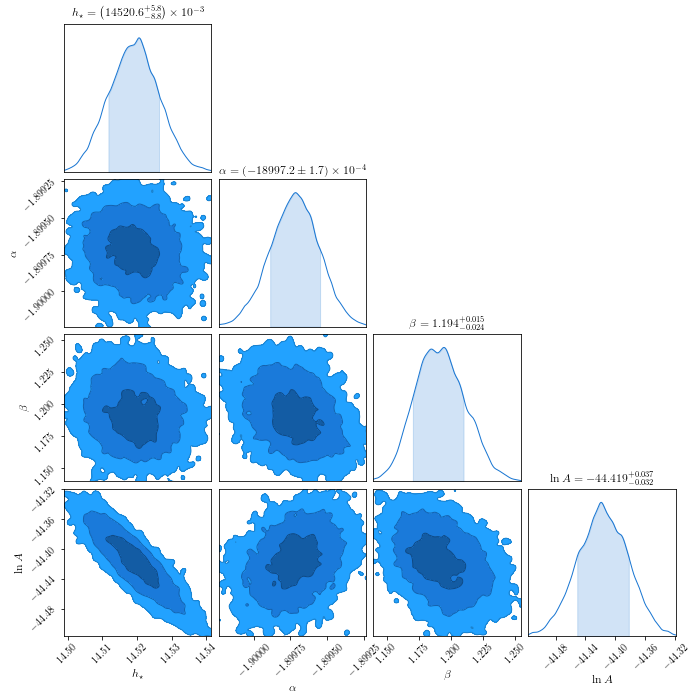

In [53]:
c = ChainConsumer().add_chain(chain_fof.reshape((-1,4)),
                              parameters=[r'$h_\star$',r'$\alpha$',r"$\beta$",r'$\ln A$'], 
                              walkers=50)
fig = c.plot(figsize="PAGE")
if fig_folder:
    fig.savefig(join(fig_folder,"n2gc_triangle.pdf"))

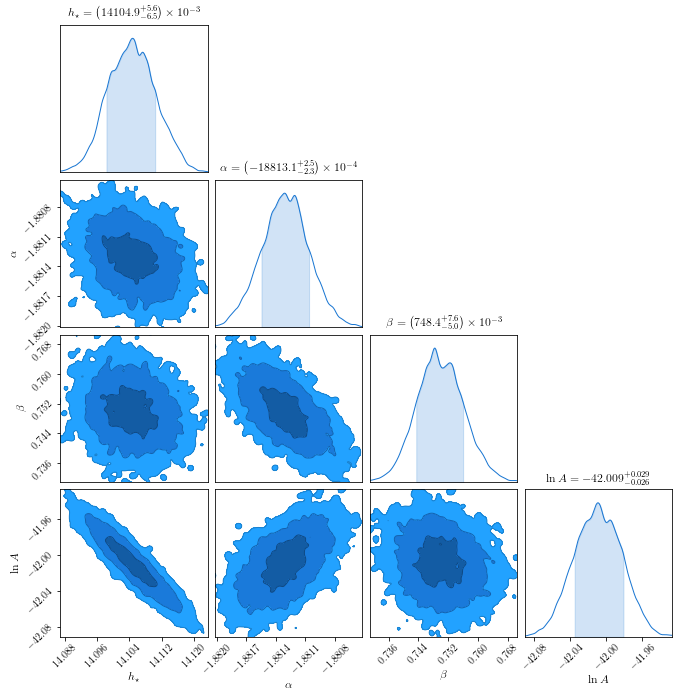

In [89]:
c = ChainConsumer().add_chain(chain_so.reshape((-1,4)),
                              parameters=[r'$h_\star$',r'$\alpha$',r"$\beta$",r'$\ln A$'], 
                              walkers=50)
fig = c.plot(figsize="PAGE")

### Residual Plot

Importantly, we want to check if the actual results look good against the data, when binned.

In [90]:

# A function to create histograms from raw masses, and conver them to dn/dm.
# It also sets edge values in which a whole bin is not sampled to nan for visual purposes.
def bin_masses(masses,nm, V, bins=50):
    hist, edges = np.histogram(np.log10(masses), bins,weights=nm)
    centres = (edges[1:] + edges[:-1]) / 2
    dx = centres[1] - centres[0]
    dn = hist.astype("float") / (10 ** centres  *float(V)* dx * np.log(10))#
    poisson_error = np.sqrt(hist.astype("float"))/ (10 ** centres  *float(V)* dx * np.log(10))#
    
    try:
        hist0 = np.where(hist != 0)[0][0]
        dn[hist0] = 0
        hist[hist0] = 0
        poisson_error[hist0] = 0
    except IndexError:
        pass
    
    try:
        histN = np.where(hist != 0)[0][-1]
        dn[histN] = 0
        hist[histN] = 0
        poisson_error[histN] = 0
    except IndexError:
        pass
    
    dn[hist == 0] = np.nan
    return centres, dn, hist, poisson_error

resids = {}
for jj, ftype in enumerate(['fof','so']):
    resids[ftype] = {}
        
    m,nm = data[ftype]['m'], data[ftype]['nm']
    
    # Generate total density of each sim
    resids[ftype]['rho'] = [np.sum(x*nx)/L**3 for x,nx,L in zip(m,nm,[140.0,560.0])]

    # Calculate the total mmin and mmax for all sims in the suite
    mmin = np.min([x.min() for x in m])
    mmax = np.max([x.max() for x in m])

    # Generate the bin structure
    bins = np.linspace(np.log10(mmin), np.log10(mmax),50)
    bin_centres = (bins[1:] + bins[:-1])/2

    # Generate the dn/dm from the sims
    resids[ftype]["dndm"] = []
    resids[ftype]["hist"] = []
    resids[ftype]["err"] = []
    for mi,nmi,L in zip(m,nm,[140.0,560.0]):
        _,dn,h_, err = bin_masses(mi,nmi,L**3,bins)
        resids[ftype]["dndm"].append(dn)
        resids[ftype]["hist"].append(h_)
        resids[ftype]["err"].append(err)
        

    # The final best-fit object.
    parms = np.mean([chain_fof, chain_so][jj], axis=(0,1))
    norm = parms[3] # downhill_res[0].x[3]
    resids[ftype]['fit'] = MRP(logm = bin_centres,logHs=parms[0],alpha=parms[1],beta=parms[2],norm=norm)

Along with the best-fit MRP, we want to show the published mass function of the data, which we get from the hmf package.

In [57]:
from hmf import MassFunction

h = MassFunction(hmf_model="Ishiyama", cosmo_params={"Om0":0.31, "Ob0":0.048, "H0":68.0},
                 sigma_8=0.83, n=0.96,lnk_min=-15, lnk_max=15, dlnk=0.01,Mmin=bin_centres[0],Mmax=bin_centres[-1]+0.001,
                 dlog10m=bin_centres[1]-bin_centres[0])

Finally we draw the actual plot.

/home/steven/miniconda3/envs/mrpy/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in less
/home/steven/miniconda3/envs/mrpy/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in less
/home/steven/miniconda3/envs/mrpy/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less


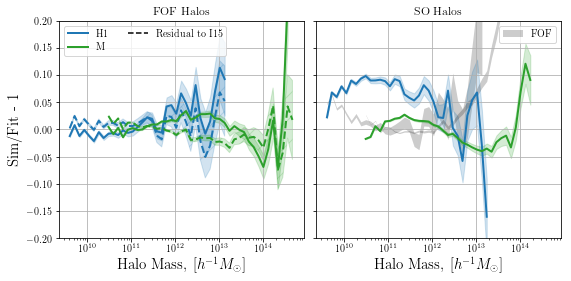

In [114]:
fig, ax = plt.subplots(1,2, figsize=(9,4), sharex=True, sharey=True, 
                       subplot_kw={"xscale":'log', 'ylim':(-0.2,0.2)},
                       gridspec_kw={"wspace":0.05})
ftypes = ['fof','so']

for jj, ftype in enumerate(ftypes):
    for i,(dn,hst,err, label,col) in enumerate(zip(resids[ftype]['dndm'],
                                              resids[ftype]['hist'], 
                                              resids[ftype]['err'], 
                                              ["H1","M"],
                                              ["C0",'C2'])):
        fit = resids[ftype]['fit']
        
        # Plot alternative type in grey
        if jj==1:
            dn_, err_ = resids[ftypes[(jj+1)%2]]['dndm'][i], resids[ftypes[(jj+1)%2]]['err'][i]
            frac = (dn_/fit.dndm()) - 1
            err_ = err_/fit.dndm() 
            mask = np.abs(frac)<0.3
            #ax[jj].plot(10**bin_centres[mask],frac[mask],label=ftypes[(jj+1)%2].upper() if i else "",
            #           color='k',lw=2, alpha=0.1)
            ax[jj].fill_between(10**bin_centres[mask],
                             frac[mask] - err_[mask], frac[mask]+err_[mask],
                                label=ftypes[(jj+1)%2].upper() if i else "",
                             color='k', alpha=0.2, facecolor=None, edgecolor=None, lw=0)
        
        
        # Residuals to MRP. Mask trailing bits so that poisson noise doesn't dominate the view
        frac = (dn/fit.dndm()) - 1
        err_ = err/fit.dndm()
        mask = np.abs(frac)<0.3
        ax[jj].plot(10**bin_centres[mask],frac[mask],label=label if not jj else "",color=col,lw=2)
        ax[jj].fill_between(10**bin_centres[mask],
                         frac[mask] - err_[mask], frac[mask]+err_[mask],
                         color=col, alpha=0.2)
        

        if ftype=="fof":
            frac = (dn/h.dndm) - 1
            err_ = err/h.dndm
            mask = np.abs(frac)<0.3
            ax[jj].plot(10**bin_centres[mask],frac[mask],color=col,lw=2, ls='--')
            ax[jj].fill_between(10**bin_centres[mask],
                             frac[mask] - err_[mask], frac[mask]+err_[mask],
                             color=col, alpha=0.2, hatch='/')
    
        

        ax[jj].set_xlabel(r"Halo Mass, [$h^{-1}M_\odot$]",fontsize=15)
        ax[jj].grid(True)
# Rsidual of Rockstar to MRP
#frac = dndm_rock/fit.dndm() -1
#plt.plot(10**bin_centres[np.abs(frac)<0.3],frac[np.abs(frac)<0.3], color="C3",label="SO")

# Legend item for I15 fit
ax[0].plot([0],[0],label="Residual to I15",ls="--",color="k")
ax[0].set_title("FOF Halos")
ax[1].set_title("SO Halos")

# PLOT STYLING
#ax[0].xscale('log')
#plt.grid(True)
#plt.ylim((-0.2,0.2))
#plt.ylim((-0.05,0.05))
ax[0].set_ylabel("Sim/Fit - 1",fontsize=15)
for jj in range(2):
    ax[jj].legend(loc=0,ncol=2)

# Save for the paper!
if fig_folder:
    plt.savefig(join(fig_folder,"n2gc_fof_simul.pdf"))

We notice that the residuals from MRP are very similar in magnitude to those from the full EPS-based fit, over a fairly wide range of masses. Note that it seems that the MRP will diverge more significantly below the mass threshold than the EPS fit. In any case, both diverge significantly less than the *same simulation* with haloes found with a spherical overdensity technique. 